# Localizing Particles using LodeSTAR

This tutorial demonstrates how to use LodeSTAR to localize particles in three steps:
Create the dataset, train LodeSTAR, and calibrate the detection.

This notebook has been modified and extended from the [DeepLearningCrashCourse](https://github.com/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch06_SelfSupervised/ec06_1_lodestar/lodestar.ipynb).

In [ ]:
import deeptrack as dt, deeplay as dp, imageio
import torch, matplotlib.pyplot as plt, numpy as np
from torch.utils.data import DataLoader
import random
from pathlib import Path

# Create the Dataset

The idea of LodeSTAR is to enforce data symmetries with data augmentation.
This permits to train with very few data samples.
To get such samples, we can simulate the particle that will be imaged or take a crop directly from the video.
In our case, we will get crops from the VIP particles provided in the challenge.

## Simulated particle

Define a particle located near the center of the image ...

In [ ]:
image_size = 128

particle = dt.PointParticle(
    position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
)

... define the optical system as a fluorescence microscope ...

In [ ]:
optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size))

... create the  simulation pipeline ...

In [ ]:
simulation = optics(particle) >> dt.NormalizeMinMax(0, 1) \
    >> dt.Gaussian(sigma=0.1) >> dt.MoveAxis(-1, 0) \
    >> dt.pytorch.ToTensor(dtype=torch.float32)

... create the train and test datasets ...

In [ ]:
train_dataset_sim = dt.pytorch.Dataset(simulation, length=100)
test_dataset_sim  = dt.pytorch.Dataset(simulation & particle.position, length=5000)

In [ ]:
train_dataset_sim[0][0].shape

torch.Size([1, 128, 128])

In [ ]:
dataloader_sim = DataLoader(train_dataset_sim, batch_size=4, shuffle=True)

... and plot some generated particles and their position.

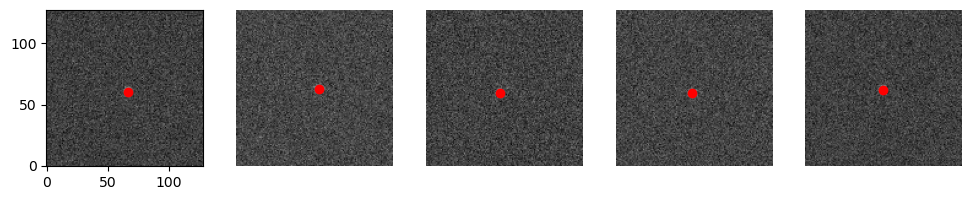

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    image, position = test_dataset_sim[i]
    ax.imshow(image[0], cmap="gray", origin="lower")
    ax.scatter(position[1], position[0], c="r")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

## Crop from video

To take a crop from the video we must load the video.

In [ ]:
!ls ../../../nanoninjas/data/raw/starting_kit/track_1/exp_0/

ensemble_labels.txt   traj_labs_fov_3.txt  videos_fov_16.tiff
ens_labs_fov_0.txt    traj_labs_fov_4.txt  videos_fov_17.tiff
ens_labs_fov_10.txt   traj_labs_fov_5.txt  videos_fov_18.tiff
ens_labs_fov_11.txt   traj_labs_fov_6.txt  videos_fov_19.tiff
ens_labs_fov_12.txt   traj_labs_fov_7.txt  videos_fov_1.tiff
ens_labs_fov_13.txt   traj_labs_fov_8.txt  videos_fov_2.tiff
ens_labs_fov_14.txt   traj_labs_fov_9.txt  videos_fov_3.tiff
ens_labs_fov_15.txt   trajs_fov_0.csv	   videos_fov_4.tiff
ens_labs_fov_16.txt   trajs_fov_10.csv	   videos_fov_5.tiff
ens_labs_fov_17.txt   trajs_fov_11.csv	   videos_fov_6.tiff
ens_labs_fov_18.txt   trajs_fov_12.csv	   videos_fov_7.tiff
ens_labs_fov_19.txt   trajs_fov_13.csv	   videos_fov_8.tiff
ens_labs_fov_1.txt    trajs_fov_14.csv	   videos_fov_9.tiff
ens_labs_fov_2.txt    trajs_fov_15.csv	   vip_idx_fov_0.txt
ens_labs_fov_3.txt    trajs_fov_16.csv	   vip_idx_fov_10.txt
ens_labs_fov_4.txt    trajs_fov_17.csv	   vip_idx_fov_11.txt
ens_labs_fov_5.txt    trajs_

In [ ]:
video_path = Path('../../../nanoninjas/data/raw/public_data/track_1/exp_0/videos_fov_0.tiff')
video_path = Path('../../../nanoninjas/data/raw/starting_kit/track_1/exp_0/videos_fov_0.tiff')
traj_path  = Path('../../../nanoninjas/data/raw/starting_kit/track_1/exp_0/trajs_fov_0.csv')

In [ ]:
def take_VIP_coords_from_mask(mask):
    idx_unordered = np.argwhere(mask != 255)[:,[2,1,0]]
    # restore order of appearence
    # Create a dictionary to store the particle IDs
    particle_ids = {}
    id_counter = 0
    # Iterate over the array to assign particle IDs
    for c in idx_unordered[:,[1,2]]:
        if tuple(c) not in particle_ids:
            particle_ids[tuple(c)]       = id_counter
            particle_ids[tuple(c+[1,0])] = id_counter+1
            particle_ids[tuple(c+[0,1])] = id_counter+2
            particle_ids[tuple(c+[1,1])] = id_counter+3
            id_counter += 4
    return np.array([idx_unordered[particle_ids[tuple(c)]] for c in idx_unordered[:,[1,2]]])

In [ ]:
def read_video_from_path(path):
    try:
        reader = imageio.get_reader(path)
    except Exception as e:
        print("Error opening video file: ", e)
        return None
    frames = [np.array(im) for im in reader]
    vip_mask = frames[0]
    vip_idx, s = np.unique(vip_mask, return_index=True)
    # np.unique sorts by value, but we want to preserve appearance order
    vip_idx, s = vip_idx[:-1], s[:-1]  # discard the last, 255
    vip_idx = vip_idx[np.argsort(s)]
    vip_start = take_VIP_coords_from_mask(vip_mask)
    # assert len(vip_idx)==vip_start.shape[0]
    return np.stack(frames[1:]), vip_start, vip_idx

In [ ]:
video, vip_start, vip_idx = read_video_from_path(video_path)
video = torch.from_numpy(video).float().unsqueeze(1) / 256 # <--normalize
video.shape # T, C, H, W = video.shape

torch.Size([200, 1, 128, 128])

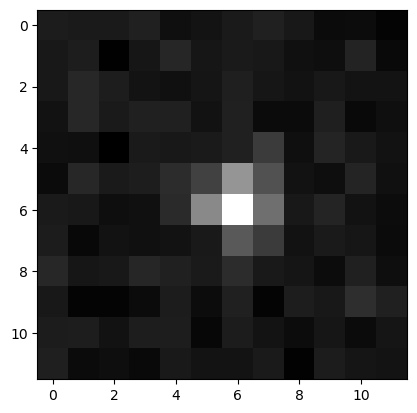

In [ ]:
crop=video[0, :, 99:111, 107:119]
plt.imshow(crop[0], cmap='gray');

With this image of a single particle, we can populate our dataset using different transformation, that is data augmentation.

In [ ]:
training_pipeline = (
    dt.Value(crop)
    >> dt.Multiply(lambda: np.random.uniform(0.8, 1.2))
    >> dt.Add(lambda: np.random.uniform(-0.2, 0.2))
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.05))
    # >> dt.NormalizeMinMax()
    #>> dt.Poisson(snr=7, background=0.1)
    # >> dt.FlipLR(augment=1)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

In [ ]:
train_dataset = dt.pytorch.Dataset(training_pipeline, length=256, replace=False)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, )

In [ ]:
train_dataset[256][0].shape

IndexError: list index out of range

In [ ]:
b = next(iter(dataloader))

In [ ]:
b

[tensor([[[0.3940, 0.3082, 0.3726, 0.4198, 0.3726, 0.3855, 0.3769, 0.3554,
           0.3468, 0.4112, 0.3339],
          [0.4241, 0.3940, 0.3640, 0.3554, 0.3683, 0.3983, 0.3726, 0.3597,
           0.3769, 0.3640, 0.3640],
          [0.4241, 0.3855, 0.4069, 0.4069, 0.3597, 0.4069, 0.3382, 0.3382,
           0.3983, 0.3339, 0.3511],
          [0.3511, 0.3039, 0.3855, 0.3769, 0.3855, 0.4069, 0.4842, 0.3511,
           0.4155, 0.3812, 0.3597],
          [0.4241, 0.3855, 0.3940, 0.4413, 0.5057, 0.7590, 0.5529, 0.3597,
           0.3468, 0.4155, 0.3554],
          [0.3769, 0.3468, 0.3554, 0.4327, 0.7204, 1.0810, 0.6431, 0.3769,
           0.4155, 0.3597, 0.3425],
          [0.3296, 0.3597, 0.3554, 0.3597, 0.3812, 0.5744, 0.4842, 0.3597,
           0.3855, 0.3726, 0.3382],
          [0.3726, 0.3769, 0.4198, 0.4069, 0.3855, 0.4413, 0.3812, 0.3683,
           0.3425, 0.4069, 0.3468],
          [0.3167, 0.3167, 0.3382, 0.3897, 0.3425, 0.4026, 0.3167, 0.3940,
           0.3769, 0.4456, 0.4069],
 

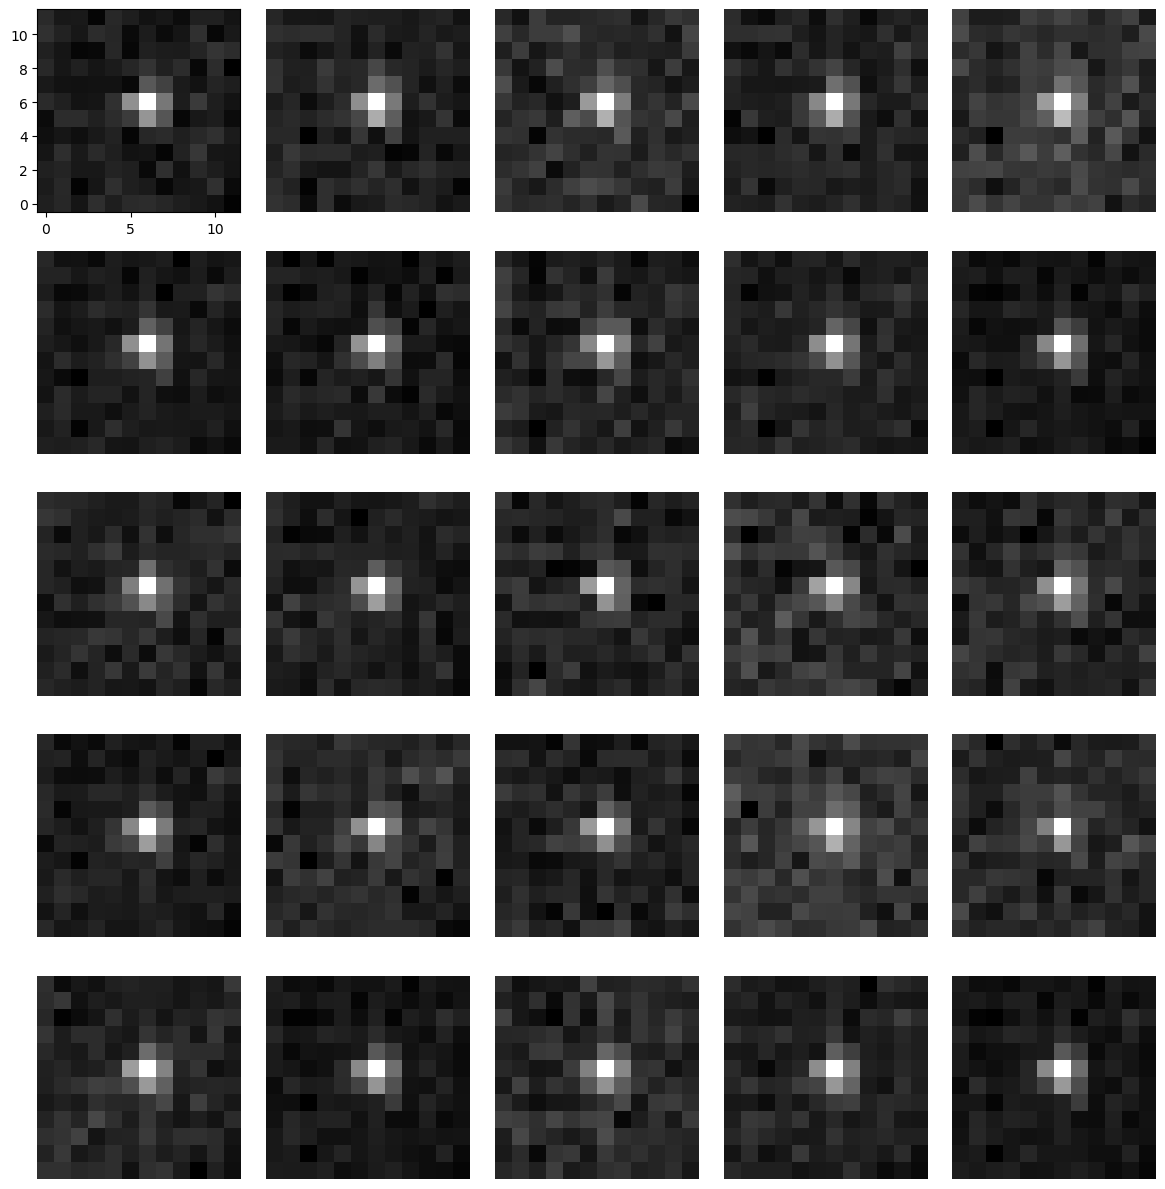

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    image, = train_dataset[i]
    ax.imshow(image[0], cmap="gray", origin="lower")
    # ax.scatter(position[1], position[0], c="r")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

## Multiple crops

Let's take examples from the videos by using the provided VIP masks and augment them.

In [ ]:
video, vip_start, vip_idx = read_video_from_path(video_path)
video = torch.from_numpy(video).float().unsqueeze(1) / 256
video.shape # T, C, H, W = video.shape

torch.Size([200, 1, 128, 128])

[ 3 33]
[10 54]
[13 70]
[ 21 106]
[38 67]
[42 73]
[81 99]
[85 40]
[103  41]
[118  38]


<Figure size 640x480 with 0 Axes>

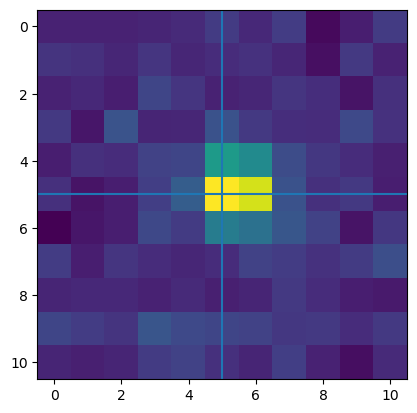

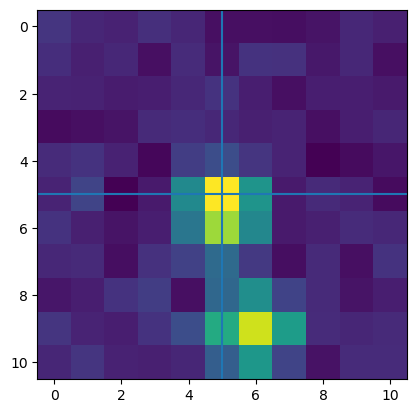

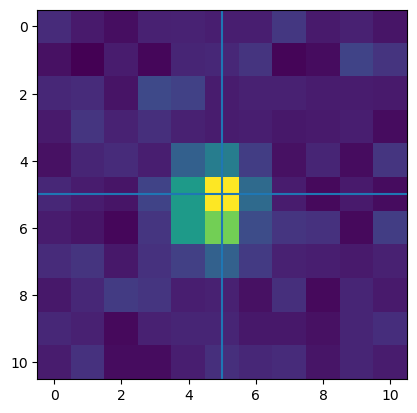

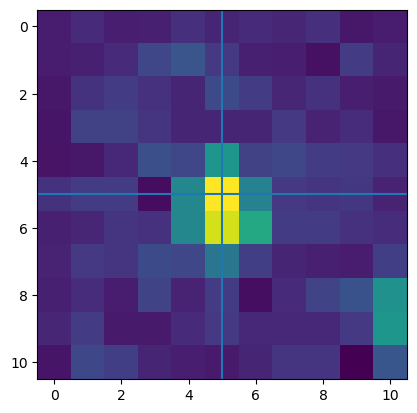

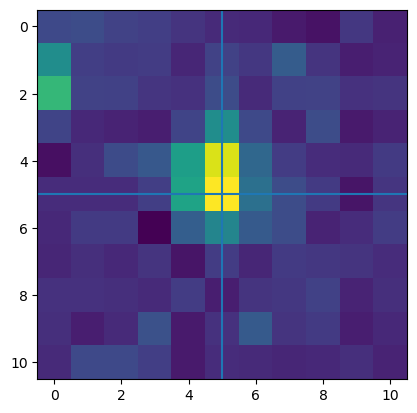

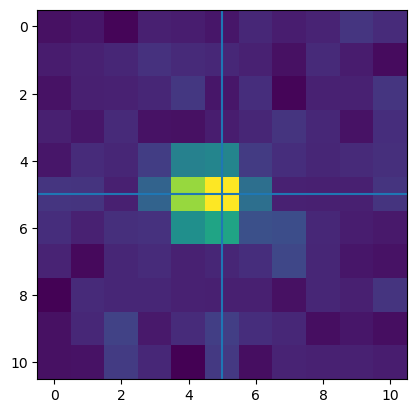

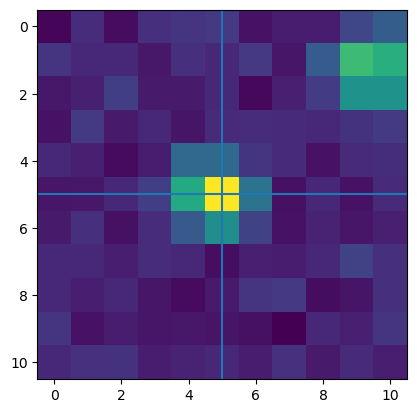

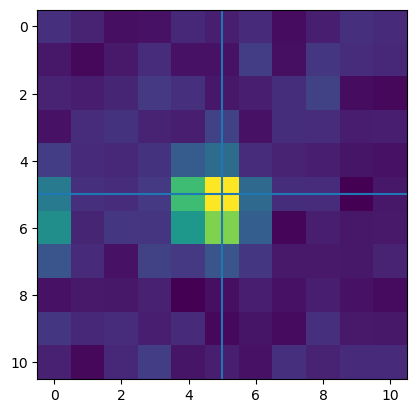

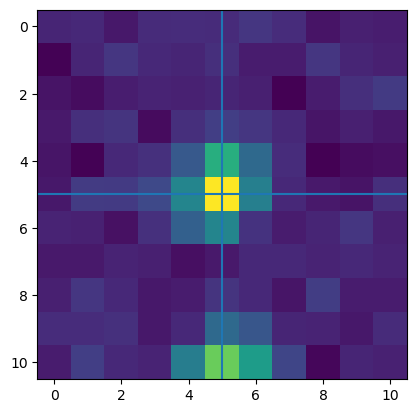

In [ ]:
crop_size = 11 # Tried from 6 to 12, the bigger the more information there is
# with an odd number particles are centered
ml, mr = -crop_size//2+1, +crop_size//2+1 # margins
assert mr-ml==crop_size, f'{mr,ml,crop_size=}' 
vip_crops = []
for i in range(len(vip_start)//4):
    plt.figure();
    vs = vip_start[i*4:(i+1)*4,[2,1]]
    vs_max_i = torch.argmax(video[0,:,*vs.T])
    vs = vs[vs_max_i]
    print(vs)
    if np.any(vs<=(crop_size//2)) or np.any(vs>=(128-crop_size//2)): continue # avoid particle close to the borders 
    vip_crop = video[0, :, vs[0]+ml:vs[0]+mr, vs[1]+ml:vs[1]+mr]
    vip_crops.append(vip_crop)
    plt.imshow(vip_crop[0],);
    plt.axhline(crop_size//2);plt.axvline(crop_size//2);
    # TODO handle two close particles
    # TODO handle particles close to the borders
    # hint for both: maybe mask images of the close particles with zeros as if it the border

In [ ]:
vip_crop.shape

torch.Size([1, 11, 11])

In [ ]:
vip_crops = np.stack(vip_crops,axis=0)

We do the above for all the videos available in the challenge dataset.

In [ ]:
vip_crops = []
for exp in range(12):
    # video_path = Path(f'../../../nanoninjas/data/raw/starting_kit/track_1/exp_{exp}/videos_fov_0.tiff')
    video_path = Path(f'/media/scratrch_data/nanoninjas/data/raw/challenge/track_1/exp_{exp}/videos_fov_0.tiff')
    
    # load video and mask
    video, vip_start, vip_idx = read_video_from_path(video_path)
    # preprocess (to numpy, float, channel dim, normalize)
    video = torch.from_numpy(video).float().unsqueeze(1) / 256 # T, C, H, W = video.shape
    # take crops
    crop_size = 11 # from 6 to 12
    ml, mr = -crop_size//2+1, +crop_size//2+1 # margins
    assert mr-ml==crop_size, f'{mr,ml,crop_size=}' 
    # non centered
    # for vip_s in vip_start[::4]:
    #     if np.any(vip_s[[1,2]]<=(crop_size//2)) or np.any(vip_s[[1,2]]>=(128-crop_size//2)): continue # avoid particle close to the borders 
    #     vip_crop = video[0, :, vip_s[2]+ml:vip_s[2]+mr, vip_s[1]+ml:vip_s[1]+mr, ]
    #     vip_crops.append(vip_crop)
    # centered
    for i in range(len(vip_start)//4):
        vs = vip_start[i*4:(i+1)*4,[2,1]]
        vs_max_i = torch.argmax(video[0,:,*vs.T])
        vs = vs[vs_max_i]
        if np.any(vs<=(crop_size//2)) or np.any(vs>=(128-crop_size//2)): continue # handle particle close to the borders 
        vip_crop = video[0, :, vs[0]+ml:vs[0]+mr, vs[1]+ml:vs[1]+mr]
        vip_crops.append(vip_crop)
vip_crops = np.stack(vip_crops,axis=0)

In [ ]:
vip_crops.shape

(113, 1, 11, 11)

Flipping the images doubles the dataset size.

In [ ]:
vip_crops = np.concatenate((vip_crops,vip_crops.transpose(0,1,3,2)))

Then, we apply a set of transformations as before.

In [ ]:
import random
random.choice(['2',3,4])

3

In [ ]:
training_set = dt.Value(lambda: random.choice(vip_crops)) 

In [ ]:
training_pipeline = (
    # >> dt.NormalizeMinMax()
       dt.Multiply(      lambda: np.random.uniform( 0.6, 1.8))
    >> dt.Add(           lambda: np.random.uniform(-0.2, 0.2))
    >> dt.Gaussian(sigma=lambda: np.random.uniform( 0,   0.05))
    #>> dt.Poisson(snr=7, background=0.1)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

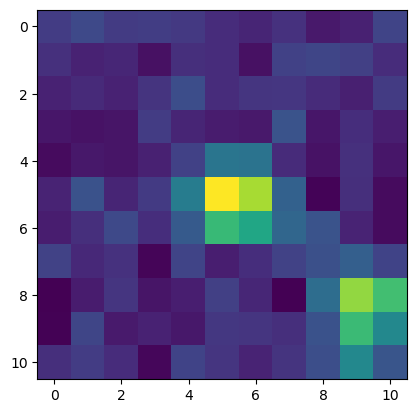

In [ ]:
# insìred by https://github.com/DeepTrackAI/DeepTrack2/blob/develop/examples/LodeSTAR/07.track_3D_holography.ipynb
x = (training_set >> training_pipeline).update()()
plt.imshow(x[0]);

In [ ]:
vip_crops.shape

(10, 1, 11, 11)

We keep our crops and add a bunch of transformed samples to the final dataset.

In [ ]:
ds = np.concatenate((vip_crops, [(training_set >> training_pipeline).update()() for _ in range(vip_crops.shape[0]*10)]))

In [ ]:
ds.shape

(2486, 1, 11, 11)

In [ ]:
dt.pytorch.Dataset??

Init signature:
dt.pytorch.Dataset(
    pipeline,
    inputs=None,
    length=None,
    replace: Union[bool, float] = False,
    float_dtype: Union[torch.dtype, str, NoneType] = 'default',
)
Docstring:     
An abstract class representing a :class:`Dataset`.

All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
:meth:`__len__`, which is expected to return the size of the dataset by many
:class:`~torch.utils.data.Sampler` implementations and the default options
of :class:`~torch.utils.data.DataLoader`. Subclasses could also
optionally implement :meth:`__getitems__`, for speedup batched samples
loading. This method accepts list of indices of samples of batch and returns
list of samples.

.. note::
  :class:`~torch.utils.data.DataLoader` by default constructs an index
  sampler that yields integral indices.  To make it

In [ ]:
train_dataset = dt.pytorch.Dataset((training_set >> training_pipeline), length=512, replace=False)

In [ ]:
dataloader = DataLoader(ds, batch_size=32, shuffle=True, )

In [ ]:
b = next(iter(dataloader))

In [ ]:
b

tensor([[[[0.2864, 0.1893, 0.2160,  ..., 0.2540, 0.2456, 0.2717],
          [0.2847, 0.2789, 0.1723,  ..., 0.2751, 0.2494, 0.2676],
          [0.2664, 0.3084, 0.2983,  ..., 0.3088, 0.2330, 0.2670],
          ...,
          [0.2008, 0.2915, 0.2615,  ..., 0.2355, 0.2255, 0.2345],
          [0.2905, 0.2944, 0.2834,  ..., 0.2383, 0.2771, 0.2495],
          [0.2594, 0.2604, 0.2868,  ..., 0.1979, 0.2051, 0.2768]]],


        [[[0.3159, 0.3350, 0.2684,  ..., 0.3326, 0.4189, 0.3771],
          [0.3429, 0.3118, 0.3584,  ..., 0.4373, 0.3884, 0.4607],
          [0.2647, 0.3673, 0.3051,  ..., 0.2864, 0.3549, 0.3229],
          ...,
          [0.2717, 0.2870, 0.2451,  ..., 0.2544, 0.2971, 0.1938],
          [0.3524, 0.3033, 0.4449,  ..., 0.2669, 0.4110, 0.3109],
          [0.3093, 0.3585, 0.3177,  ..., 0.3450, 0.2681, 0.3017]]],


        [[[0.2524, 0.2372, 0.2892,  ..., 0.2450, 0.3022, 0.3026],
          [0.3305, 0.2669, 0.3097,  ..., 0.3893, 0.2982, 0.2783],
          [0.3359, 0.3144, 0.3386,  ..

In [ ]:
b[0].shape

torch.Size([32, 1, 12, 12])

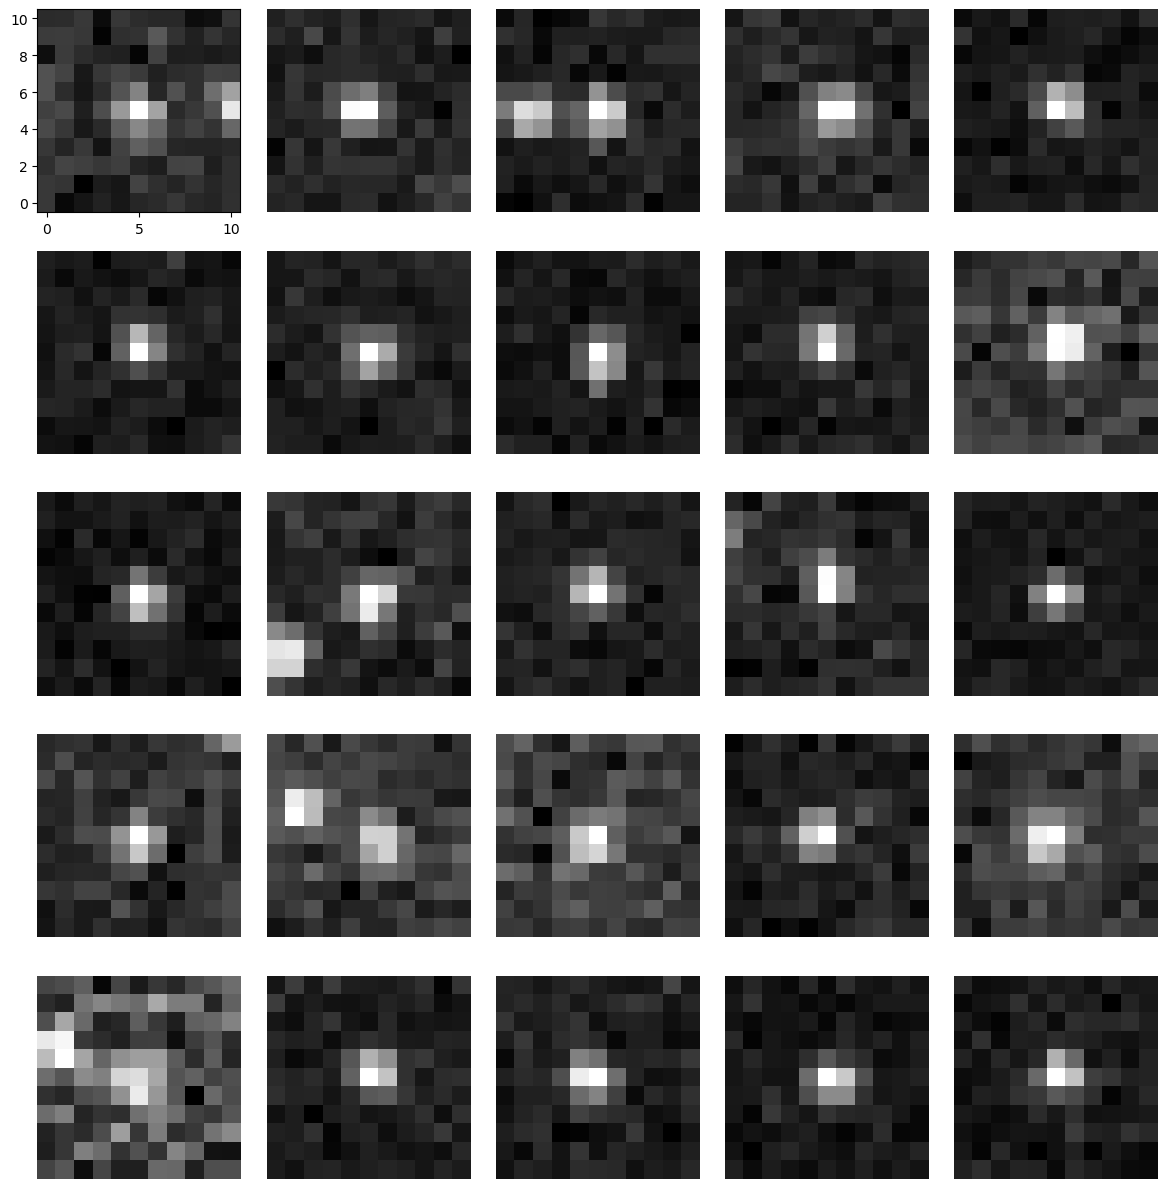

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    image = b[i][0]
    ax.imshow(image, cmap="gray", origin="lower")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

IndexError: index 18 is out of bounds for axis 0 with size 18

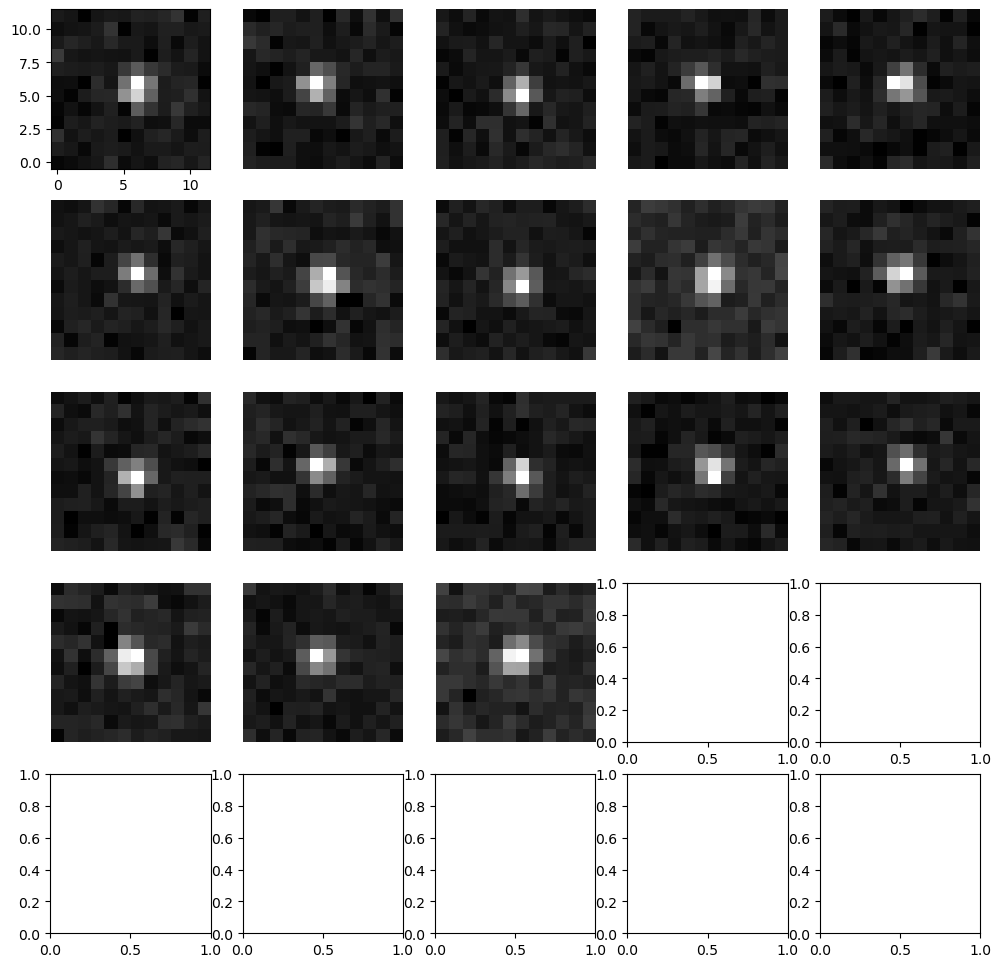

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(vip_crops[i,0], cmap="gray", origin="lower")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

# Train LodeSTAR

`deeplay` library makes very easy to train LodeSTAR, just instantiate a model and a trainer, and call fit.

In [ ]:
# instantiate model with GPU if available
with torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'):
    lodestar = dp.LodeSTAR(optimizer=dp.Adam(lr=1e-4),).build()

In [ ]:
# and trainer
trainer_lodestar = dp.Trainer(max_epochs=50,) # 300

In [ ]:
next(lodestar.parameters()).device

device(type='cuda', index=0)

In [ ]:
lodestar

LodeSTAR(
  (model): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3-8): 6 x Conv2dBlock(
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (9): Conv2dBlock(
        (layer): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
  )
  (between_loss): L1Loss()
  (within_loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.0001)
  (

In [ ]:
lodestar??

Signature:   lodestar(*args, **kwargs)
Type:        LodeSTAR
String form:
LodeSTAR(
  (model): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3-8): 6 x Conv2dBlock(
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (9): Conv2dBlock(
        (layer): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
  )
  (between_loss): L

In [ ]:
# TODO: integrate with deeplay
# from lightning.pytorch.tuner import Tuner
# # Create a Tuner
# tuner = Tuner(trainer_lodestar)

# # finds learning rate automatically
# # sets hparams.lr or hparams.learning_rate to that learning rate
# tuner.lr_find(lodestar)

/home/gfernandez/miniforge3/envs/steproids/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /media/scratrch_data/gfernandez/deeplay/tutorials/lightning_logs/version_7/checkpoints exists and is not empty.


AttributeError: When using the learning rate finder, either `model` or `model.hparams` should have one of these fields: ('lr', 'learning_rate'). If your model has a different name for the learning rate, set it with `.lr_find(attr_name=...)`.

In [ ]:
fit_log = trainer_lodestar.fit(lodestar, dataloader)

/home/gfernandez/miniforge3/envs/steproids/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/gfernandez/miniforge3/envs/steproids/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:461: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ConvolutionalNeuralNetwork │  251 K │ train │
│ 1 │ between_loss  │ L1Loss                     │      0 │ train │
│ 2 │ within_loss   │ L1Loss                     │      0 │ train │
│ 3 │ train_metrics │ MetricCollection           │      0 │ train │
│ 4 │ val_metrics   │ MetricCollection           │      0 │ train │
│ 5 │ test_metrics  │ MetricCollection           │      0 │ train │
│ 6 │ optimizer     │ Adam                       │      0 │ train │
└───┴───────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 251 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 251 K                                                                                                
Total estimated model params size (MB): 1

Output()

/home/gfernandez/miniforge3/envs/steproids/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Plotting the loss is a bit unintuitive.

In [ ]:
# print loss
# fit_log.plot()

In [ ]:
lodestar.trainer.history.__dict__ # https://github.com/DeepTrackAI/deeplay/blob/develop/tutorials/getting-started/GS111_first_model.ipynb

{'_history': {'train_between_image_disagreement_epoch': [{'epoch': 0,
    'step': 108,
    'value': 0.7329586744308472},
   {'epoch': 1, 'step': 216, 'value': 0.6813091039657593},
   {'epoch': 2, 'step': 324, 'value': 0.6430848240852356},
   {'epoch': 3, 'step': 432, 'value': 0.6780359148979187},
   {'epoch': 4, 'step': 540, 'value': 0.671914279460907},
   {'epoch': 5, 'step': 648, 'value': 0.6624693870544434},
   {'epoch': 6, 'step': 756, 'value': 0.6388059258460999},
   {'epoch': 7, 'step': 864, 'value': 0.551047682762146},
   {'epoch': 8, 'step': 972, 'value': 0.3716157078742981},
   {'epoch': 9, 'step': 1080, 'value': 0.2587145268917084},
   {'epoch': 10, 'step': 1188, 'value': 0.2365145981311798},
   {'epoch': 11, 'step': 1296, 'value': 0.2161625623703003},
   {'epoch': 12, 'step': 1404, 'value': 0.20788384974002838},
   {'epoch': 13, 'step': 1512, 'value': 0.21612225472927094},
   {'epoch': 14, 'step': 1620, 'value': 0.1893649697303772},
   {'epoch': 15, 'step': 1728, 'value': 0.

In [ ]:
loss_dis_e_5 = [e['value'] for e in lodestar.trainer.history._history['train_between_image_disagreement_epoch']]

In [ ]:
loss_dis_e_4 = [e['value'] for e in lodestar.trainer.history._history['train_between_image_disagreement_epoch']]

In [ ]:
loss_dis_e_3 = [e['value'] for e in lodestar.trainer.history._history['train_between_image_disagreement_epoch']]

In [ ]:
loss_dis_e_2 = [e['value'] for e in lodestar.trainer.history._history['train_between_image_disagreement_epoch']]

In [ ]:
loss_dis_e = [e['value'] for e in lodestar.trainer.history._history['train_between_image_disagreement_epoch']]

In [ ]:
loss_dis_s = [e['value'] for e in lodestar.trainer.history._step_history['train_between_image_disagreement_step']]

In [ ]:
loss_win_e = [e['value'] for e in lodestar.trainer.history._history['train_within_image_disagreement_epoch']]

In [ ]:
loss_win_s = [e['value'] for e in lodestar.trainer.history._step_history['train_within_image_disagreement_step']]

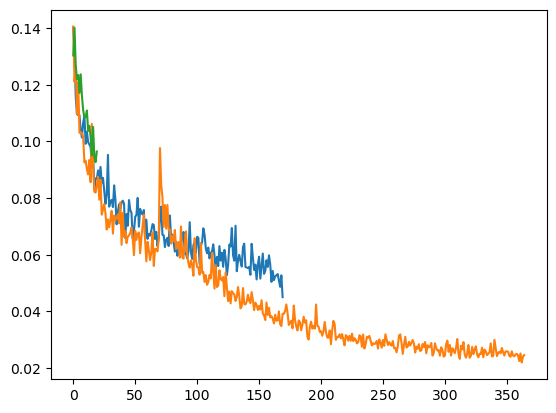

In [ ]:
plt.plot(loss_dis_e[30:]);plt.plot(np.concatenate((loss_dis_e_2[30:],loss_dis_e_3[5:])));
plt.plot(loss_dis_e_4[30:]);

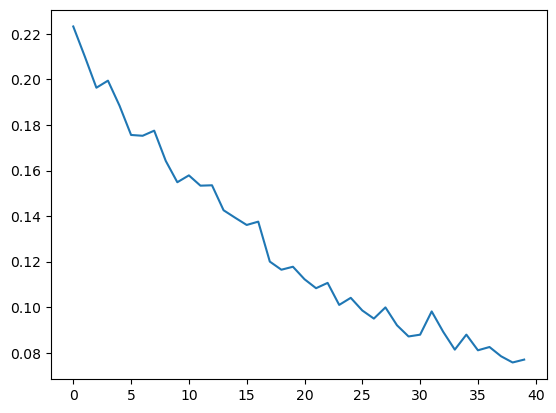

In [ ]:
plt.plot(loss_dis_e_5[10:]);

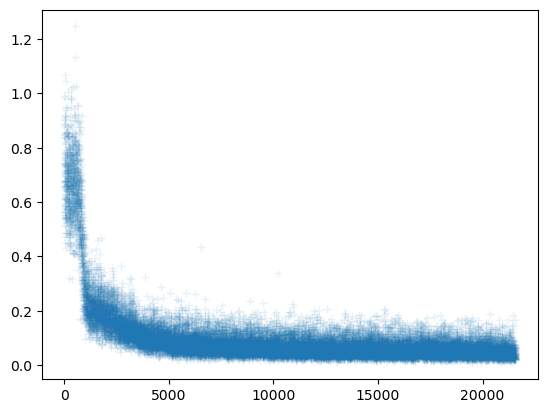

In [ ]:
plt.plot(loss_dis_s[30:],'+',alpha=0.1);

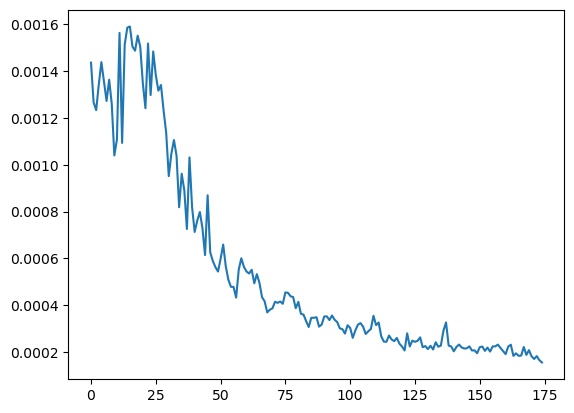

In [ ]:
plt.plot(loss_win_e[25:]);

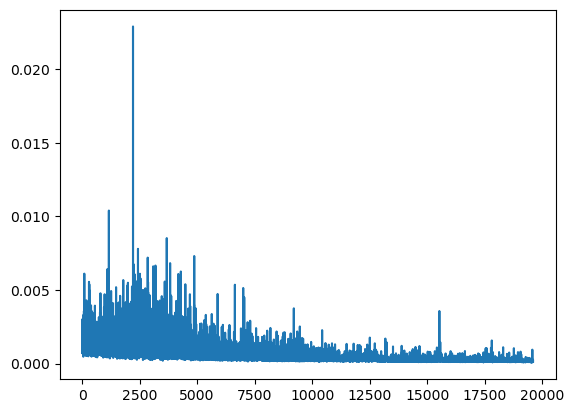

In [ ]:
plt.plot(loss_win_s[2000:]);

## Save/load the model

In [ ]:
# save model
torch.save(lodestar.state_dict(), "lodestar_centered_crops.pth")  # Saving the model.

In [ ]:
# load weights on an instance of the model
lodestar.load_state_dict(torch.load("../../STEProids/models/lodestar_centered_crops.pth"))

<All keys matched successfully>

# Calibrate detection

In [ ]:
alpha = 0.01  # (big)low alpha for very (un)similar shapes
beta = 1-alpha
cutoff = 0.2
mode = "constant"

In [ ]:
video.shape

torch.Size([200, 1, 128, 128])

In [ ]:
with torch.inference_mode():
    lodestar_preds = lodestar.detect(video, alpha=alpha, beta=beta, 
                                 mode="constant", cutoff=cutoff)

In [ ]:
len(lodestar_preds), lodestar_preds[0].shape

(200, (20, 2))

In [ ]:
lodestar_preds[0].T[[1,0]]

array([[ 57.32307 ,  73.52423 , 108.62755 ,  32.781914,  74.93877 ,
         39.00125 ,  43.816902,  34.981678,  79.21219 , 102.240524,
         34.18215 ,  47.759766, 110.8866  ,  29.354048,  43.823647,
         95.3509  , 111.24524 ,  41.639183,  86.163284,  41.004467],
       [  7.930436,  14.515398,  19.936855,  28.49166 ,  39.150295,
         50.1587  ,  54.698048,  70.05469 ,  72.80437 ,  80.73796 ,
         79.77541 ,  79.87753 ,  91.23363 , 101.42302 , 102.48894 ,
        105.86785 , 113.91224 , 117.71718 , 119.72232 , 120.83203 ]],
      dtype=float32)

In [ ]:
a=lodestar(video[0:1])

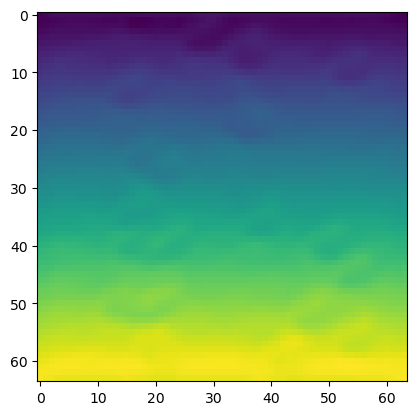

In [ ]:
plt.imshow(a[0,0,].detach().cpu().numpy());

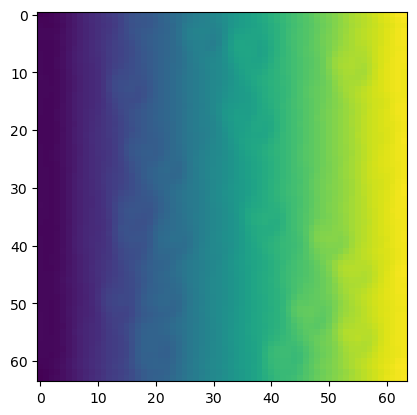

In [ ]:
plt.imshow(a[0,1,].detach().cpu().numpy());

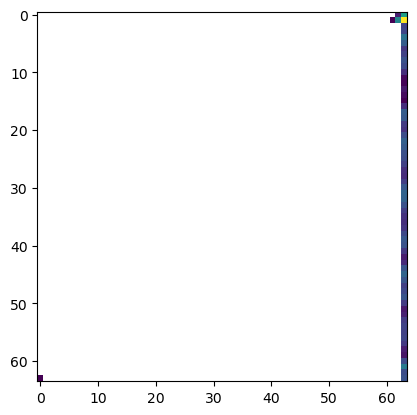

In [ ]:
plt.imshow(a[0,2,].detach().cpu().numpy(), norm='log');

In [ ]:
score = lodestar.get_detection_score(a[0,:-1], a[0,-1:], alpha, beta)

In [ ]:
local_max = lodestar.find_local_maxima(a[0,:-1], score, cutoff, 'constant')

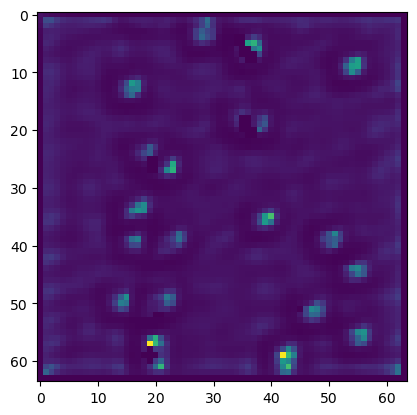

In [ ]:
plt.imshow(score);

In [ ]:
# TODO is downsampling necessary ? Is it harmful in our case?

In [ ]:
i=3

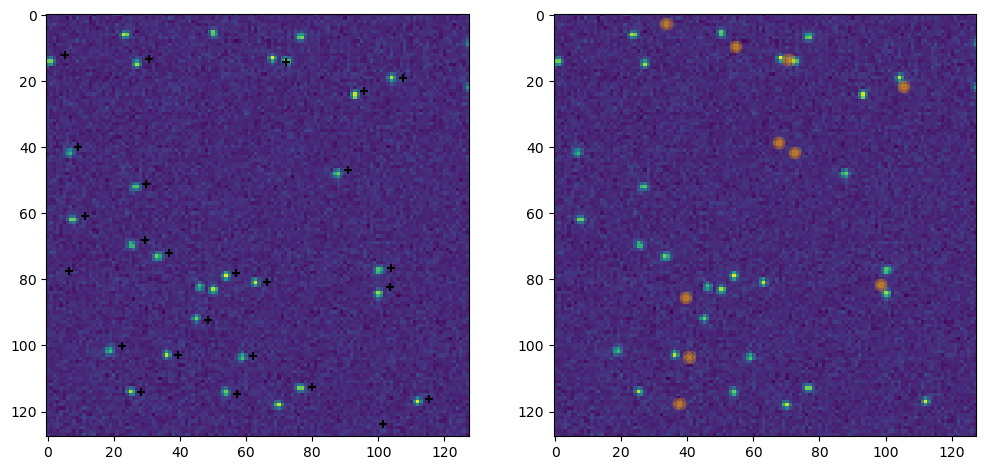

In [ ]:
# i-=1
fig, axs = plt.subplots(1,2, figsize=(12,12))
axs[0].imshow(video[i,0].cpu());
axs[1].imshow(video[i,0].cpu());
axs[1].scatter(*vip_start[:,1:].T,c='orange', alpha=0.2);
axs[0].scatter(*(lodestar_preds[i].T[[1,0]]),marker='+',c='k');

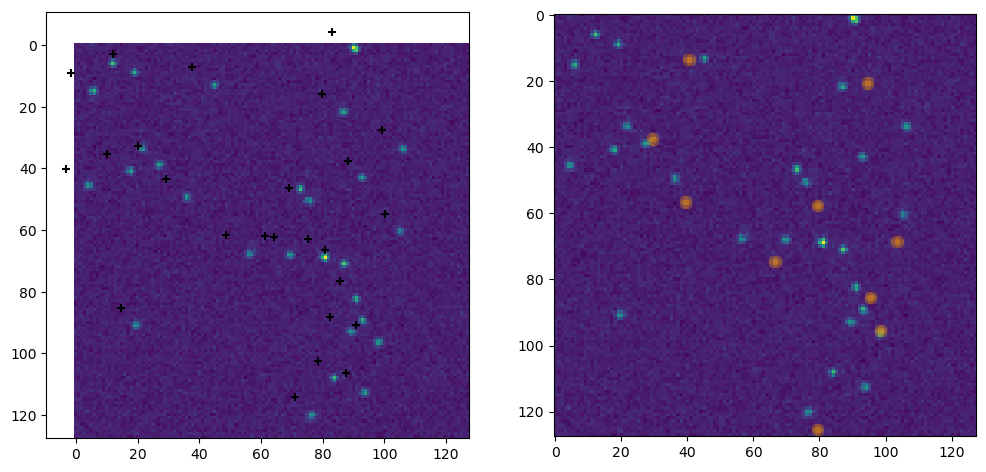

In [ ]:
# i-=1
fig, axs = plt.subplots(1,2, figsize=(12,12))
axs[0].imshow(video[i,0].cpu());
axs[1].imshow(video[i,0].cpu());
axs[1].scatter(*vip_start[:,1:].T,c='orange', alpha=0.2);
axs[0].scatter(*(lodestar_preds[i].T[[1,0]]),marker='+',c='k');

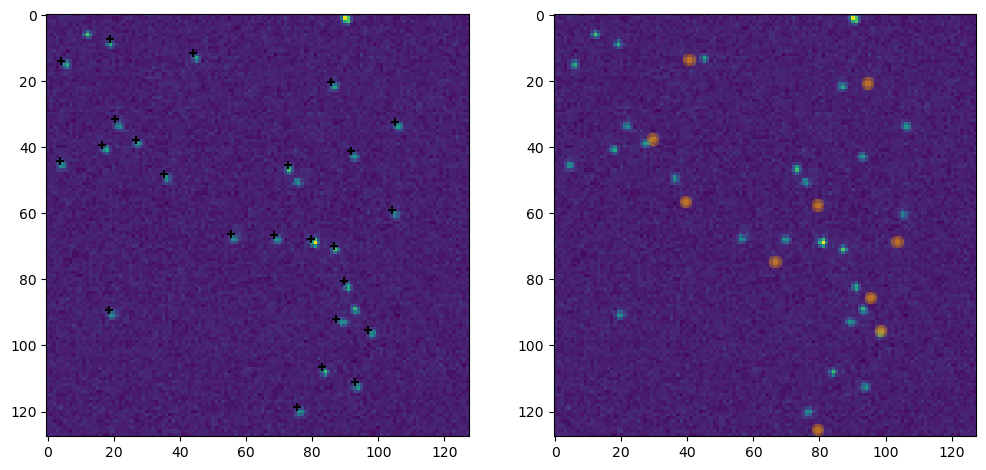

In [ ]:
# i-=1
fig, axs = plt.subplots(1,2, figsize=(12,12))
axs[0].imshow(video[i,0].cpu());
axs[1].imshow(video[i,0].cpu());
axs[1].scatter(*vip_start[:,1:].T,c='orange', alpha=0.2);
axs[0].scatter(*(lodestar_preds[i].T[[1,0]]),marker='+',c='k');

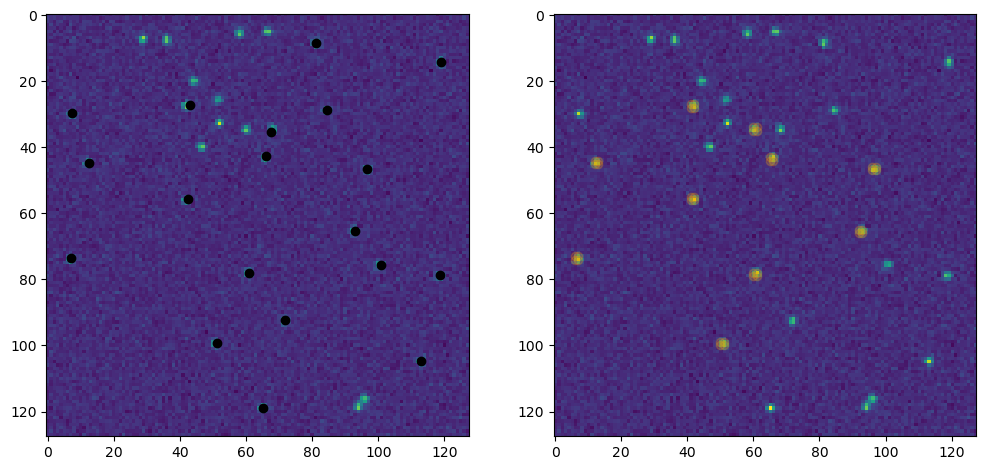

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,12))
axs[0].imshow(video[0,0].cpu());
axs[1].imshow(video[0,0].cpu());
axs[1].scatter(*vip_start[:,1:].T,c='orange', alpha=0.2);
axs[0].scatter(*(lodestar_preds[0].T[[1,0]]),c='k');

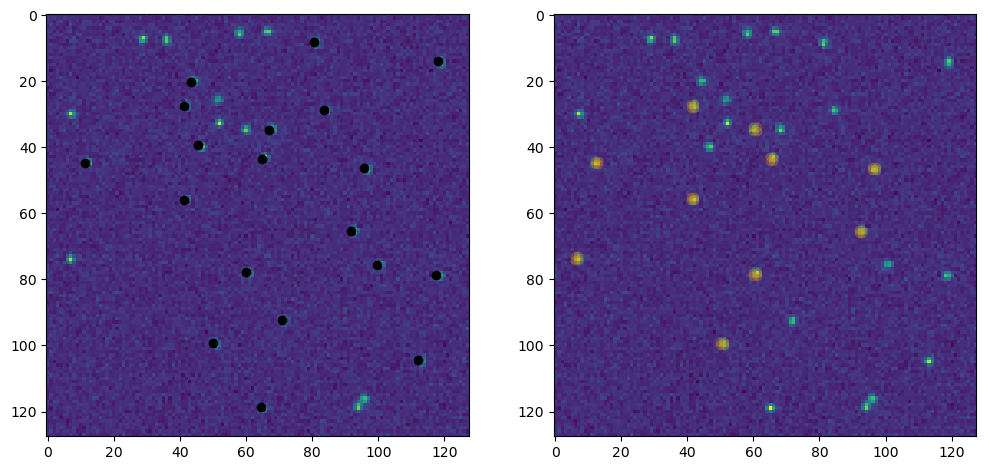

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,12))
axs[0].imshow(video[0].cpu());
axs[1].imshow(video[0].cpu());
axs[1].scatter(*vip_start[:,1:].T,c='orange', alpha=0.2);
axs[0].scatter(*(lodestar_preds[0].T[[1,0]]),c='k');

## TODO Benchmark detections to find the best parameters

# Detect particles in ANDI videos and save

In [ ]:
!ls ../../../nanoninjas/data/raw/challenge/track_1/exp_0   #starting_kit/track_1/exp_0/

videos_fov_0.tiff   videos_fov_17.tiff	videos_fov_24.tiff  videos_fov_4.tiff
videos_fov_10.tiff  videos_fov_18.tiff	videos_fov_25.tiff  videos_fov_5.tiff
videos_fov_11.tiff  videos_fov_19.tiff	videos_fov_26.tiff  videos_fov_6.tiff
videos_fov_12.tiff  videos_fov_1.tiff	videos_fov_27.tiff  videos_fov_7.tiff
videos_fov_13.tiff  videos_fov_20.tiff	videos_fov_28.tiff  videos_fov_8.tiff
videos_fov_14.tiff  videos_fov_21.tiff	videos_fov_29.tiff  videos_fov_9.tiff
videos_fov_15.tiff  videos_fov_22.tiff	videos_fov_2.tiff
videos_fov_16.tiff  videos_fov_23.tiff	videos_fov_3.tiff


In [ ]:
public_data_path = Path('../../../nanoninjas/data/raw/challenge/') # make sure the folder has this name or change it

In [ ]:
import os
path_submit = '../../data/submit/20240714/'
path_intermediate_results = path_submit + 'proc/'
if not os.path.exists(path_intermediate_results):   os.makedirs(path_intermediate_results)

In [ ]:
from tqdm.auto import trange

In [ ]:
def get_video_from_path(path):
    try:
        reader = imageio.get_reader(path)
    except Exception as e:
        print("Error opening video file: ", e)
        return None
    frames = [np.array(im) for im in reader]
    return np.stack(frames[1:])

In [ ]:
# load model
# instantiate model with GPU if available
with torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'):
    lodestar = dp.LodeSTAR(optimizer=dp.Adam(lr=1e-4),).build()

# load weights
lodestar.load_state_dict(torch.load("../../STEProids/models/lodestar_centered_crops.pth"))

<All keys matched successfully>

In [ ]:
# Define the number of experiments and number of FOVS
N_EXP  = 12  # 13 
N_FOVS = 30

track = 1

# The intermediate results (detections) go in the folders generated above
path_track = path_intermediate_results + f'track_{track}/'

In [ ]:
for exp in trange(N_EXP):
    path_exp = Path(path_track + f'exp_{exp}/')
    # the folder has to exist for writing the results file therein
    if not os.path.exists(path_exp):    os.makedirs(path_exp)
    for fov in trange(N_FOVS):
        # We read the corresponding tiff file
        video_path = public_data_path/f'track_{track}/exp_{exp}/videos_fov_{fov}.tiff'
        video = get_video_from_path(video_path)
        # preprocess the video
        video = torch.from_numpy(video).float().unsqueeze(1) / 256
        # detect all particles 
        # (big)low alpha for very (un)similar shapes
        alpha = 0.01  ;  beta = 1-alpha  ;  cutoff = 0.2
        with torch.inference_mode():
            lodestar_preds = lodestar.detect(video, alpha=alpha, beta=beta, # T',N',2
                                             mode="constant", cutoff=cutoff)
        # TODO assert preds are positive
        # save
        break
        np.save(path_exp/f'detections_fov_{fov}', np.array(lodestar_preds, dtype=object), allow_pickle=True)
    break
    print(f"Saved at {path_exp/f'detections_fov_{fov}.npy'}")

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
!ls ../../data/submit/20240714/proc/track_1/exp_3

detections_fov_0.npy   detections_fov_19.npy  detections_fov_28.npy
detections_fov_10.npy  detections_fov_1.npy   detections_fov_29.npy
detections_fov_11.npy  detections_fov_20.npy  detections_fov_2.npy
detections_fov_12.npy  detections_fov_21.npy  detections_fov_3.npy
detections_fov_13.npy  detections_fov_22.npy  detections_fov_4.npy
detections_fov_14.npy  detections_fov_23.npy  detections_fov_5.npy
detections_fov_15.npy  detections_fov_24.npy  detections_fov_6.npy
detections_fov_16.npy  detections_fov_25.npy  detections_fov_7.npy
detections_fov_17.npy  detections_fov_26.npy  detections_fov_8.npy
detections_fov_18.npy  detections_fov_27.npy  detections_fov_9.npy


In [ ]:
# check results
detections = np.load(path_exp/f'detections_fov_{0}.npy', allow_pickle=True)

In [ ]:
detections

array([array([[ 11.032705,  66.7399  ],
              [ 16.968437,  52.180626],
              [ 18.266115,  31.17231 ],
              [ 19.248629,  80.561134],
              [ 31.12537 , 124.22497 ],
              [ 34.18649 ,  15.019601],
              [ 30.491072,  43.79302 ],
              [ 31.960543,  68.1585  ],
              [ 41.954082,  28.382404],
              [ 47.325623, 117.1339  ],
              [ 52.382175,  86.87427 ],
              [ 57.578056,  32.271214],
              [ 62.049828,  71.30147 ],
              [ 65.80086 ,  94.642975],
              [ 67.923485,  12.257449],
              [ 68.59923 ,  27.637644],
              [ 67.35237 ,  71.22577 ],
              [ 74.696846,  84.29266 ],
              [ 94.40105 ,  92.596504],
              [108.64942 ,  13.077194],
              [107.14576 ,  32.99299 ],
              [108.249306,  97.37593 ],
              [118.79086 ,  66.56388 ],
              [124.59836 ,  34.41051 ],
              [124.88026 ,  89.39634 ],


In [ ]:
lodestar_preds